In [46]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, re

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 80)
pd.set_option('display.max_rows', 100)

sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

expt_dir = '/net/pulsar/home/koes/mtr22/gan/torch_training'
os.chdir(expt_dir)
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/net/pulsar/home/koes/mtr22/gan/torch_training'

In [107]:
molport_params = param_search.ParamSpace(
    data_root   ='/net/pulsar/home/koes/mtr22/molport',
    rec_molcache='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rec.molcache2',
    lig_molcache='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_lig.molcache2',
    train_file  ='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_train0.types',
    test_file   ='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_test0.types',
)

crossdock_params = param_search.ParamSpace(
    data_root   ='/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output',
    rec_molcache='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_rec.molcache2',
    lig_molcache='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_lig.molcache2',
    train_file  ='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_train0.types',
    test_file   ='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_test0.types',
)

all_params = []
for random_seed in range(3):
    for model_type in ['GAN', 'VAEGAN', 'CGAN', 'CVAEGAN']: #['AE', 'VAE', 'CE', 'CVAE']:
        
        is_gan = model_type.endswith('GAN')
        is_vaegan = model_type.endswith('VAEGAN')
        is_cond = model_type.startswith('C')
        gan_loss_types = 'wx' if is_gan else '0'

        for gan_loss_type in gan_loss_types:
            is_wgan = (gan_loss_type == 'w')

            model_params = param_search.ParamSpace(
                random_seed=random_seed,
                caffe_init=False,
                do_continue=False,
                model_type=model_type,
                gan_loss_type=gan_loss_type,
                gan_loss_wt=10.0 if is_vaegan else 1.0,
                optim_type='RMSprop' if is_wgan else 'Adam',
                
                n_gen_train_iters=1 if is_wgan else 2,
                gen_lr=0.0000001 if is_wgan else 0.00001,
                gen_grad_clip=0,
                gen_batch_norm=0,
                gen_spectral_norm=2,
                
                n_disc_train_iters=[2, 4, 8] if is_wgan else 2,
                disc_lr=0.000001 if is_wgan else 0.00001,
                disc_grad_clip=0,
                disc_batch_norm=0,
                disc_spectral_norm=2,

                disc_n_filters=32 if is_wgan else 16,
                disc_n_levels=4 if is_wgan else 3,
                disc_conv_per_level=3 if is_wgan else 1,
            )
            
            if is_cond:
                model_params.update(crossdock_params)
            else:
                model_params.update(molport_params)
                
            all_params.append(model_params)

# NOTE dual encoder models require 12gb GPUs

sum(len(p) for p in all_params)

48

In [108]:
name_format = 'train_{model_type}_10_{n_disc_train_iters}_{gan_loss_type}_{random_seed}'

for template_file in ['train.config', 'train.sh']:

    job_files = param_search.setup(
        expt_dir=expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=sum(map(list, all_params), [])
    )

job_files

['/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_4_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_8_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_x_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_4_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_8_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_x_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_2_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_4_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_8_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_2_x_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/to

# Submit training jobs to cluster

In [119]:
job_ids = param_search.submit(job_files)
print(job_ids)

[6740202, 6740203, 6740204, 6740205, 6740206, 6740207, 6740208, 6740209, 6740210, 6740211, 6740212, 6740213, 6740214, 6740215, 6740216, 6740217, 6740218, 6740219, 6740220, 6740221, 6740222, 6740223, 6740224, 6740225, 6740226, 6740227, 6740228, 6740229, 6740230, 6740231, 6740232, 6740233, 6740234, 6740235, 6740236, 6740237, 6740238, 6740239, 6740240, 6740241, 6740242, 6740243, 6740244, 6740245, 6740246, 6740247, 6740248, 6740249]


In [175]:
df = pd.DataFrame(dict(
    group_name=[
        'non_gan', # non-GANs and WGANs, no atom fitting - the WGANs all diverged to nan, non-GAN still going strong
        'train_fitting', # try 3 random seeds, 3 latent sizes, GANs + WGANs, and atom fitting metrics - VAEGANs oom, GANs nan
        'train_fitting2', # use gen+disc gradient clipping, 64gb mem
        'train_fitting3', # fix missing module in atom_fitting.py
        'train_fitting4', # fix indent error in dkoes_fitting.py
        'train_fitting5', # fix zero divide and track memory usage
        'train_fitting6', # fix random seeds, n_latent, memory leak, try GANs with batchnorm + disc grad clip, WGANs with spectral norm, both with G/D ratios 1:2 or 1:4
        'train_fitting7', # try lower WGAN lr again, more disc iters, more gen iters for standard GAN
        'train_fitting8', # train_10 jobs: config files, diff G/D lrs, 100 grad clip, diff order
        'train_fitting9', # add scalar metrics, put job_params back in train.sh, use spectral norm instead of grad clip, default weight init, smaller repro discriminator
    ],
    job_id=[
        [6733823, 6733824, 6733825, 6733826],
        [6736277, 6736278, 6736279, 6736280, 6736281, 6736282, 6736283, 6736284, 6736285, 6736286, 6736287, 6736288, 6736289, 6736290, 6736291, 6736292, 6736293, 6736294, 6736295, 6736296, 6736297, 6736298, 6736299, 6736300, 6736301, 6736302, 6736303, 6736304, 6736305, 6736306, 6736307, 6736308, 6736309, 6736310, 6736311, 6736312, 6736313, 6736314, 6736315, 6736316, 6736317, 6736318, 6736319, 6736320, 6736321, 6736322, 6736323, 6736324, 6736325, 6736326, 6736327, 6736328, 6736329, 6736330, 6736331, 6736332, 6736333, 6736334, 6736335, 6736336, 6736337, 6736338, 6736339, 6736340, 6736341, 6736342, 6736343, 6736344, 6736345, 6736346, 6736347, 6736348],
        [6736473, 6736474, 6736475, 6736476, 6736477, 6736478, 6736479, 6736480, 6736481, 6736482, 6736483, 6736484, 6736485, 6736486, 6736487, 6736488, 6736489, 6736490, 6736491, 6736492, 6736493, 6736494, 6736495, 6736496, 6736497, 6736498, 6736499, 6736500, 6736501, 6736502, 6736503, 6736504, 6736505, 6736506, 6736507, 6736508, 6736509, 6736510, 6736511, 6736512, 6736513, 6736514, 6736515, 6736516, 6736517, 6736518, 6736519, 6736520, 6736521, 6736522, 6736523, 6736524, 6736525, 6736526, 6736527, 6736528, 6736529, 6736530, 6736531, 6736532, 6736533, 6736534, 6736535, 6736536, 6736537, 6736538, 6736539, 6736540, 6736541, 6736542, 6736543, 6736544],
        [6736546, 6736547, 6736548, 6736549, 6736550, 6736551, 6736552, 6736553, 6736554, 6736555, 6736556, 6736557, 6736558, 6736559, 6736560, 6736561, 6736562, 6736563, 6736564, 6736565, 6736566, 6736567, 6736568, 6736569, 6736570, 6736571, 6736572, 6736573, 6736574, 6736575, 6736576, 6736577, 6736578, 6736579, 6736580, 6736581, 6736582, 6736583, 6736584, 6736585, 6736586, 6736587, 6736588, 6736589, 6736590, 6736591, 6736592, 6736593, 6736594, 6736595, 6736596, 6736597, 6736598, 6736599, 6736600, 6736601, 6736602, 6736603, 6736604, 6736605, 6736606, 6736607, 6736608, 6736609, 6736610, 6736611, 6736612, 6736613, 6736614, 6736615, 6736616, 6736617],
        [6736618, 6736619, 6736620, 6736621, 6736622, 6736623, 6736624, 6736625, 6736626, 6736627, 6736628, 6736629, 6736630, 6736631, 6736632, 6736633, 6736634, 6736635, 6736636, 6736637, 6736638, 6736639, 6736640, 6736641, 6736642, 6736643, 6736644, 6736645, 6736646, 6736647, 6736648, 6736649, 6736650, 6736651, 6736652, 6736653, 6736654, 6736655, 6736656, 6736657, 6736658, 6736659, 6736660, 6736661, 6736662, 6736663, 6736664, 6736665, 6736666, 6736667, 6736668, 6736669, 6736670, 6736671, 6736672, 6736673, 6736674, 6736675, 6736676, 6736677, 6736678, 6736679, 6736680, 6736681, 6736682, 6736683, 6736684, 6736685, 6736686, 6736687, 6736688, 6736689],
        [6736802, 6736803, 6736804, 6736805, 6736806, 6736807, 6736808, 6736809, 6736810, 6736811, 6736812, 6736813, 6736814, 6736815, 6736816, 6736817, 6736818, 6736819, 6736820, 6736821, 6736822, 6736823, 6736824, 6736825, 6736826, 6736827, 6736828, 6736829, 6736830, 6736831, 6736832, 6736833, 6736834, 6736835, 6736836, 6736837, 6736838, 6736839, 6736840, 6736841, 6736842, 6736843, 6736844, 6736845, 6736846, 6736847, 6736848, 6736849, 6736850, 6736851, 6736852, 6736853, 6736854, 6736855, 6736856, 6736857, 6736858, 6736859, 6736860, 6736861, 6736862, 6736863, 6736864, 6736865, 6736866, 6736867, 6736868, 6736869, 6736870, 6736871, 6736872, 6736873],
        [6738318, 6738319, 6738320, 6738321, 6738322, 6738323, 6738324, 6738325, 6738326, 6738327, 6738328, 6738329, 6738330, 6738331, 6738332, 6738333, 6738334, 6738335, 6738336, 6738337, 6738338, 6738339, 6738340, 6738341, 6738342, 6738343, 6738344, 6738345, 6738346, 6738347, 6738348, 6738349, 6738350, 6738351, 6738352, 6738353, 6738354, 6738355, 6738356, 6738357, 6738358, 6738359, 6738360, 6738361, 6738362, 6738363, 6738364, 6738365],
        [6738460, 6738461, 6738462, 6738463, 6738464, 6738465, 6738466, 6738467, 6738468, 6738469, 6738470, 6738471, 6738472, 6738473, 6738474, 6738475, 6738476, 6738477, 6738478, 6738479, 6738480, 6738481, 6738482, 6738483, 6738484, 6738485, 6738486, 6738487, 6738488, 6738489, 6738490, 6738491, 6738492, 6738493, 6738494, 6738495, 6738496, 6738497, 6738498, 6738499, 6738500, 6738501, 6738502, 6738503, 6738504, 6738505, 6738506, 6738507],
        [6738804, 6738805, 6738806, 6738807, 6738808, 6738809, 6738810, 6738811, 6738812, 6738813, 6738814, 6738815, 6738816, 6738817, 6738818, 6738819, 6738820, 6738821, 6738822, 6738823, 6738824, 6738825, 6738826, 6738827, 6738828, 6738829, 6738830, 6738831, 6738832, 6738833, 6738834, 6738835, 6738836, 6738837, 6738838, 6738839, 6738840, 6738841, 6738842, 6738843, 6738844, 6738845, 6738846, 6738847, 6738848, 6738849, 6738850, 6738851],
        [6740080, 6740081, 6740082, 6740083, 6740084, 6740085, 6740086, 6740087, 6740088, 6740089, 6740090, 6740091, 6740092, 6740093, 6740094, 6740095, 6740096, 6740097, 6740098, 6740099, 6740100, 6740101, 6740102, 6740103, 6740104, 6740105, 6740106, 6740107, 6740108, 6740109, 6740110, 6740111, 6740112, 6740113, 6740114, 6740115, 6740116, 6740117, 6740118, 6740119, 6740120, 6740121, 6740122, 6740123, 6740124, 6740125, 6740126, 6740127],
    ]
)).explode('job_id')
df.groupby('group_name')['job_id'].agg(['count', 'min', 'max'])

,count,min,max
group_name,,,
non_gan,4,6733823,6733826
train_fitting,72,6736277,6736348
train_fitting2,72,6736473,6736544
train_fitting3,72,6736546,6736617
train_fitting4,72,6736618,6736689
train_fitting5,72,6736802,6736873
train_fitting6,48,6738318,6738365
train_fitting7,48,6738460,6738507
train_fitting8,48,6738804,6738851


In [176]:
import numpy as np
import glob, re
import param_search

queue_status = param_search.status()
queue_status[['job_id', 'array_idx']] = queue_status['job_id'].str.split('_', expand=True).apply(pd.to_numeric)

df = df[df.group_name.isin(['non_gan', 'train_fitting9'])]
df = df.merge(queue_status, on='job_id', how='left')

def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    f = glob.glob('*/{}.*'.format(x['job_id']))
    if f:
        return os.path.dirname(f[0])
    # else cancelled before running

def find_job_state(x):
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

df['work_dir'] = df.apply(find_work_dir, axis=1)
df['job_name'] = df['work_dir'].map(catch_exc(os.path.basename, TypeError))
df['job_file'] = df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
df['stdout_file'] = df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
df['stderr_file'] = df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
df['stdout'] = df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
df['stderr'] = df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
df['job_state'] = df.apply(find_job_state, axis=1)

In [177]:
gen_grad_norm_re = re.compile(r'.*(gen_grad_norm=(\S+)).*')
def parse_stdout(x):
    return float(gen_grad_norm_re.match(x).group(2))

df['gen_grad_norm'] = df['stdout'].map(catch_exc(parse_stdout, (TypeError, AttributeError)))
df.set_index(['group_name', 'job_name', 'job_id'])[['stdout_file', 'job_state', 'stdout', 'stderr']]

stdout_file  \
group_name     job_name               job_id                                                                                          
non_gan        train_AE_7             6733823              /net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_7/6733823.stdout   
               train_VAE_7            6733824             /net/pulsar/home/koes/mtr22/gan/torch_training/train_VAE_7/6733824.stdout   
               train_CE_7             6733825              /net/pulsar/home/koes/mtr22/gan/torch_training/train_CE_7/6733825.stdout   
               train_CVAE_7           6733826            /net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAE_7/6733826.stdout   
train_fitting9 train_GAN_10_2_w_0     6740080      /net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_w_0/6740080.stdout   
               train_GAN_10_4_w_0     6740081      /net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_4_w_0/6740081.stdout   
               train_GAN_10_8_w_0     6740082      /net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_8_w_0/6740082.stdout   
               train_GAN_10_2_x_0     6740083      /net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_x_0/6740083.stdout   
               train_VAEGAN_10_2_w_0  6740084   /net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_w_0/6740084.stdout   
               train_VAEGAN_10_4_w_0  6740085   /net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_4_w_0/6740085.stdout   
               train_VAEGAN_10_8_w_0  6740086   /net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_8_w_0/6740086.stdout   
               train_VAEGAN_10_2_x_0  6740087   /net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_x_0/6740087.stdout   
               train_CGAN_10_2_w_0    6740088     /net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_2_w_0/6740088.stdout   
               train_CGAN_10_4_w_0    6740089     /net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_4_w_0/6740089.stdout   
               train_CGAN_10_8_w_0    6740090     /net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_8_w_0/6740090.stdout   
               train_CGAN_10_2_x_0    6740091     /net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_2_x_0/6740091.stdout   
               train_CVAEGAN_10_2_w_0 6740092  /net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_10_2_w_0/6740092.stdout   
               train_CVAEGAN_10_4_w_0 6740093  /net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_10_4_w_0/6740093.stdout   
               train_CVAEGAN_10_8_w_0 6740094  /net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_10_8_w_0/6740094.stdout   
               train_CVAEGAN_10_2_x_0 6740095  /net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_10_2_x_0/6740095.stdout   
               train_GAN_10_2_w_1     6740096      /net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_w_1/6740096.stdout   
               train_GAN_10_4_w_1     6740097      /net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_4_w_1/6740097.stdout   
               train_GAN_10_8_w_1     6740098      /net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_8_w_1/6740098.stdout   
               train_GAN_10_2_x_1     6740099      /net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_x_1/6740099.stdout   
               train_VAEGAN_10_2_w_1  6740100   /net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_w_1/6740100.stdout   
               train_VAEGAN_10_4_w_1  6740101   /net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_4_w_1/6740101.stdout   
               train_VAEGAN_10_8_w_1  6740102   /net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_8_w_1/6740102.stdout   
               train_VAEGAN_10_2_x_1  6740103   /net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_x_1/6740103.stdout   
               train_CGAN_10_2_w_1    6740104     /net/pulsar/home/koe

In [116]:
if input('Enter CANCEL to confirm: ') == 'CANCEL':
    param_search.cancel(' '.join(map(str, df[df.group_name == 'train_fitting9'].job_id)))

Enter CANCEL to confirm: CANCEL


# Read in training output metrics

In [178]:
# READ IN METRIC FILES
metrics = param_search.metrics(df[
    (df.group_name == 'train_fitting9') | (df.group_name == 'non_gan')
].job_file, metric_pat='(.*)metrics')

/net/pulsar/home/koes/mtr22/gan/torch_training/train_CE_7/train.sh No columns to parse from file
/net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_10_4_w_0/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_10_8_w_0/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_10_2_x_0/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_8_w_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_x_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_w_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_4_w_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_8_w_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_x_1/train

In [179]:
metrics['model'] = metrics['model'].fillna('gen')
metrics['real'] = metrics['real'].fillna(False)

metrics[
    metrics['iteration'] == metrics.groupby('job_name')['iteration'].transform(max)
].groupby(['job_name', 'iteration', 'phase', 'model'])[
    ['loss', 'gan_loss', 'gen_grad_norm', 'disc_grad_norm', 'lig_norm', 'lig_gen_norm']
].mean()

loss      gan_loss  \
job_name               iteration phase model                               
train_AE_7             770800    test  gen    1.409404e+01           NaN   
train_CGAN_10_2_w_0    900       test  disc   1.863078e-04  1.863078e-04   
                                       gen    2.451383e+01  2.451383e+01   
train_CGAN_10_2_x_0    0         test  disc   8.296312e-01  8.296312e-01   
                                       gen    1.132792e+00  1.132792e+00   
train_CGAN_10_4_w_0    300       test  disc   2.451813e-01  2.451813e-01   
                                       gen    7.791180e+00  7.791180e+00   
train_CGAN_10_8_w_0    200       test  disc   1.192145e-03  1.192145e-03   
                                       gen    1.432029e+01  1.432029e+01   
train_CVAEGAN_10_2_w_0 700       test  disc   5.263321e+05  4.387596e-04   
                                       gen    1.052716e+06  1.804072e+01   
train_CVAE_7           648400    test  gen    7.829005e+01           NaN   
train_GAN_10_2_w_0     31100     test  disc   8.594691e-05  8.594691e-05   
                                       gen    1.031010e+01  1.031010e+01   
train_GAN_10_2_w_1     0         test  disc   6.928133e-01  6.928133e-01   
                                       gen    6.936531e-01  6.936531e-01   
train_GAN_10_2_x_0     5900      test  disc   2.161437e-02  2.161437e-02   
                                       gen    6.932916e+00  6.932916e+00   
train_GAN_10_4_w_0     22800     test  disc   1.203216e-05  1.203216e-05   
                                       gen    1.272387e+01  1.272387e+01   
train_GAN_10_4_w_1     0         test  disc   6.928133e-01  6.928133e-01   
                                       gen    6.936531e-01  6.936531e-01   
train_GAN_10_8_w_0     14600     test  disc   1.169442e-06  1.169442e-06   
                                       gen    1.306567e+01  1.306567e+01   
train_VAEGAN_10_2_w_0  18900     test  disc   5.172354e+05  0.000000e+00   
                                       gen    1.035026e+06  3.306061e+02   
train_VAEGAN_10_2_x_0  2100      test  disc   3.783311e+05  4.199939e-05   
                                       gen    7.568452e+05  1.243757e+01   
train_VAEGAN_10_4_w_0  14600     test  disc   5.181018e+05  3.576278e-09   
                                       gen    1.036924e+06  4.850960e+02   
train_VAEGAN_10_8_w_0  1100      test  disc   5.249690e+05  0.000000e+00   
                                       gen    1.050673e+06  5.892517e+02   
train_VAE_7            809500    test  gen    5.792980e+01           NaN   

                                              gen_grad_norm  disc_grad_norm  \
job_name               iteration phase model                                  
train_AE_7             770800    test  gen       802.706872             NaN   
train_CGAN_10_2_w_0    900       test  disc             NaN             NaN   
                                       gen              NaN             NaN   
train_CGAN_10_2_x_0    0         test  disc             NaN             NaN   
                                       gen              NaN             NaN   
train_CGAN_10_4_w_0    300       test  disc             NaN             NaN   
                                       gen              NaN             NaN   
train_CGAN_10_8_w_0    200       test  disc             NaN             NaN   
                                       gen              NaN             NaN   
train_CVAEGAN_10_2_w_0 700       test  disc             NaN             NaN   
                                       gen              NaN             NaN   
train_CVAE_7           648400    test  gen      1175.753491             NaN   
train_GAN_10_2_w_0     31100     test  disc             NaN             NaN   
                                       gen              NaN             NaN   
train_GAN_10_2_w_1     0         test  disc             NaN             NaN   
                                       gen        

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/net/pulsar/home/koes/mtr22/param_search/results.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group] = df[group_cols].apply(make_group_value, axis=1)


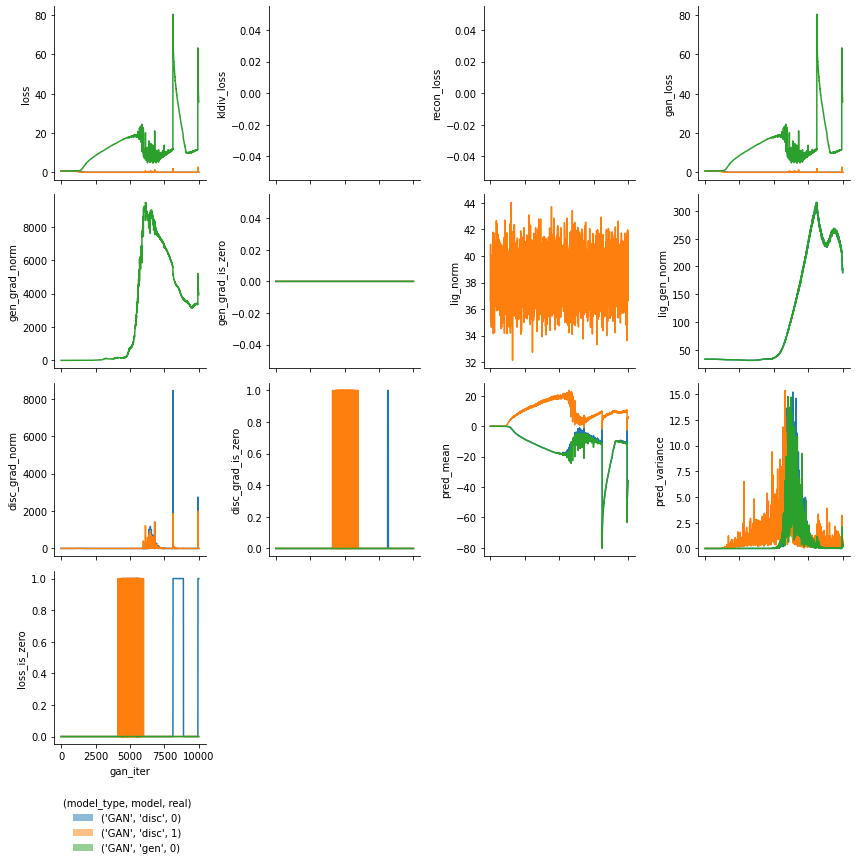

In [240]:
import numpy as np
import scipy.stats
import param_search

def safe_sem(x):
    return scipy.stats.sem(x) if len(x) > 1 else np.nan

def filled_lines(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue):
        hue_data = hue_data[~hue_data[y].isna()]
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(safe_sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h) #, marker='x')
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

n_examples = {
    '/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_train0.types':           97828036,
    '/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_train0.types': 14567805,
}

iter_bin_size = 100
#metrics['n_examples'] = metrics['train_file'].map(n_examples.get)
#metrics['epochs'] = metrics['iteration'] * metrics['batch_size'] / metrics['n_examples']
metrics['iter_bin'] = ((metrics['iteration'] // iter_bin_size) * iter_bin_size).astype(int)
metrics['gan_iter'] = metrics['iteration'] + metrics['disc_iter'] 
metrics['loss_is_nan'] = metrics['loss'].isnull()
metrics['loss_is_zero'] = (metrics['loss'] == 0)
metrics['gen_grad_is_nan'] = metrics['gen_grad_norm'].isnull()
metrics['gen_grad_is_zero'] = (metrics['gen_grad_norm'] == 0)
metrics['disc_grad_is_zero'] = (metrics['disc_grad_norm'] == 0)
metrics['lig_gen_is_nan'] = metrics['lig_gen_norm'].isnull()
metrics[~metrics['lig_gen_fit_n_atoms'].isna()]['phase'] = 'fit'
metrics['model_is_disc'] = metrics['model'] == 'disc'

model_types0 = ['AE', 'CE', 'VAE', 'CVAE']
model_types1 = ['GAN', 'CGAN', 'VAEGAN', 'CVAEGAN']

asdf = metrics.reset_index()

fig = param_search.plot(
    asdf[
        (asdf['job_name'] == 'train_GAN_10_2_w_0') &
        (asdf['gan_iter'] <= 10000) &
        #(asdf['model'] == 'disc') &
        (asdf['phase'] == 'train') &
        True
    ],
    x='gan_iter',
    y=[
        'loss', 'kldiv_loss', 'recon_loss', 'gan_loss',
        'gen_grad_norm', 'gen_grad_is_zero', 'lig_norm', 'lig_gen_norm', 
        'disc_grad_norm', 'disc_grad_is_zero', 'pred_mean', 'pred_variance', 'loss_is_zero' #'lig_gen_fit_n_atoms',
    ],
    xlim=dict(),
    ylim=dict(), #lig_gen_norm=[0, 1500]),
    hue=('model_type', 'model', 'real'),
    plot_func=filled_lines,
    n_cols=4, height=3
)

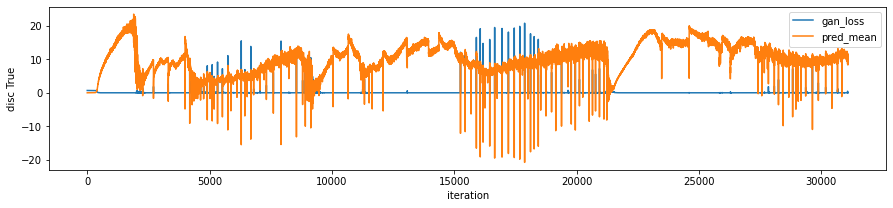

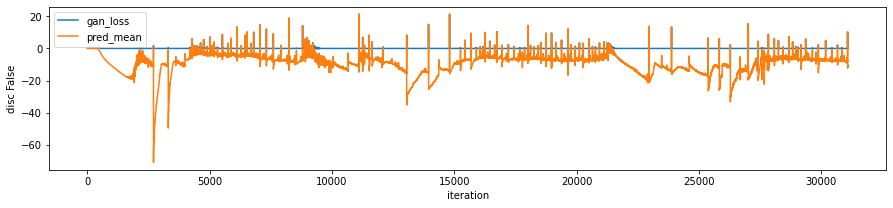

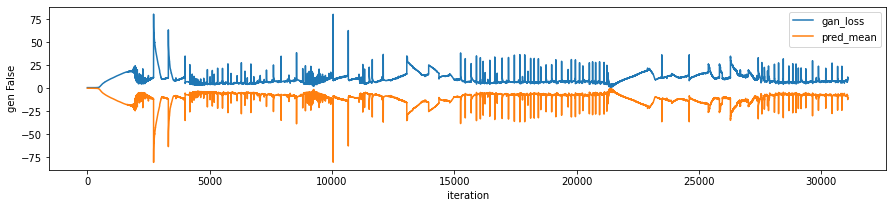

In [242]:
for model, real in [('disc', True), ('disc', False), ('gen', False)]:
    metrics[
        (metrics['job_name'] == 'train_GAN_10_2_w_0') &
        (metrics['phase'] == 'train') &
        (metrics['model'] == model) &
        (metrics['real'] == real) &
        True
    ].plot(x='iteration', y=['gan_loss', 'pred_mean'], figsize=(15, 3), ylabel='{} {}'.format(model, real))

In [248]:
metrics[
    (metrics['job_name'] == 'train_GAN_10_2_w_0') &
    (metrics['phase'] == 'train') &
    (metrics['iteration'] == 10000) &
    True
][['model', 'real', 'gan_loss', 'pred_mean', 'pred_variance']]

,model,real,gan_loss,pred_mean,pred_variance
32020,disc,True,0.000107,9.673417,1.275750
32021,disc,False,0.000036,-10.697939,0.851761
32022,gen,False,12.190516,-12.190511,0.364569


In [275]:
import torch

labels, predictions = torch.ones(10, 1), torch.normal(9.673417, np.sqrt(1.275750), (10, 1))
labels, predictions = torch.zeros(10, 1), torch.normal(-10.697939, np.sqrt(0.851761), (10, 1))
#labels, predictions = torch.ones(10, 1), torch.normal(-12.190511, np.sqrt(0.364569), (10, 1))
assert labels.shape == predictions.shape

torch.where(labels.byte(), predictions, -predictions).sum() / labels.shape[0]

tensor(10.9731)